<a href="https://colab.research.google.com/github/DILIP-SHEESH/Samsung-Prism/blob/main/phi_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Enter a prompt for watermarked text: explain quantum computing

=== Generated Watermarked Text ===
 explain quantum computing and how entangle qubit could possibly change computing forever (and why it has been so difficult to do so to date). After all, even Microsoft has had some difficulties. What role does entangle qubit play in this and how quantum computing will help our world run more fast and better than our existing technology. I will not be discussing super dense hard drives, or DNA.
Qubitalizing
QBism (Quantum by intuation/Interpretist) QBIS holds a group mindfulness meditation seminaire yearly in Vienna. It is directed at Qubitalizers (those embracing the use and importance of qubits for building a new machine).
AquamaQI
Jon Glassman began Aquamaq in the mid eighties as a way to keep his mind sharp after teaching university physics. Over the past 26 years he’s learned a lot about healing through the use quantum information as well.
I had heard about QBism but didn’'s how it h

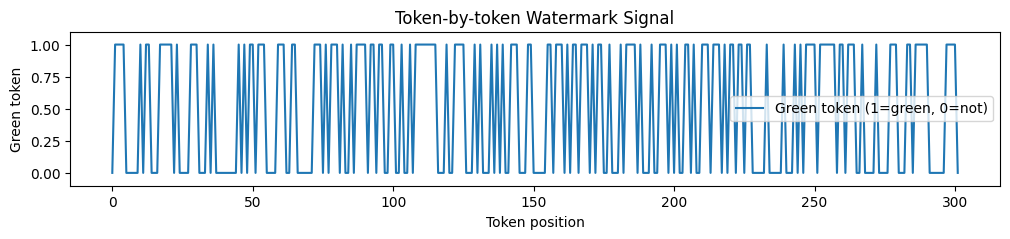


Paste your own text (or any text) to check for watermark: I had heard about QBism but didn’'s how it has been applied to medicine in practice to assist the body heal itself? How does our mind work in this model and what are healtiic energy systems? What are Quantum Intervention techniques to heal disease? I have heard of people healng themselves using this process – I’m sure there are other things that you can do with it to help the mind/body heal and promote learning/int

=== Detection Results for Your Text ===
Watermarked: False (Z-Score > 4 is considered watermarked)
Z-Score: -0.20
P-Value: 0.5801
Confidence: 42.0%

This text is NOT detected as watermarked.


In [ ]:
import torch
import torch.nn as nn
import numpy as np
from transformers import AutoModelForCausalLM, AutoTokenizer, LogitsProcessor, LogitsProcessorList
from scipy.stats import norm
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- HashNet ---
class EnhancedHashNet(nn.Module):
    def __init__(self, input_size=1, hidden_size=512, num_layers=3):
        super().__init__()
        layers = [nn.Linear(input_size, hidden_size), nn.LayerNorm(hidden_size), nn.ReLU()]
        for _ in range(num_layers - 2):
            layers += [nn.Linear(hidden_size, hidden_size), nn.LayerNorm(hidden_size), nn.ReLU(), nn.Dropout(0.1)]
        layers += [nn.Linear(hidden_size, hidden_size // 2), nn.ReLU(), nn.Linear(hidden_size // 2, 1), nn.Tanh()]
        self.net = nn.Sequential(*layers)
        self._init_weights()
    def _init_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.zeros_(module.bias)
    def forward(self, x):
        x = x.to(device)
        return (self.net(x) * (2**31)).int()

# --- Watermark Processor ---
class BipolarWatermarkProcessor(LogitsProcessor):
    def __init__(self, vocab, gamma, delta, h, hash_net, base_key=982451653, negative_ratio=0.5):
        self.vocab = vocab
        self.vocab_size = len(vocab)
        self.gamma = gamma
        self.delta = delta
        self.negative_ratio = negative_ratio
        self.h = h
        self.hash_net = hash_net
        self.base_key = base_key
        self.generator = torch.Generator(device=device)
    def _get_token_lists(self, context):
        context = context.to(device)
        norm_context = context.float() / self.vocab_size
        seed = int(self.hash_net(norm_context.unsqueeze(0)).item() + self.base_key) & 0xFFFFFFFF
        self.generator.manual_seed(seed)
        permutation = torch.randperm(self.vocab_size, device=device, generator=self.generator)
        green_size = int(self.gamma * self.vocab_size)
        red_size = int(green_size * self.negative_ratio)
        return permutation[:green_size], permutation[green_size:green_size+red_size]
    def __call__(self, input_ids, scores):
        batch_size, seq_len = input_ids.shape
        for b_idx in range(batch_size):
            start_idx = max(0, seq_len - self.h)
            context = input_ids[b_idx, start_idx:]
            if context.size(0) < self.h:
                context = torch.cat([
                    torch.zeros(self.h - context.size(0), dtype=torch.long, device=device),
                    context.to(device)
                ])
            else:
                context = context.to(device)
            green_list, red_list = self._get_token_lists(context)
            scores[b_idx][green_list] += self.delta
            scores[b_idx][red_list] -= self.delta * 0.5
        return scores

# --- Encoder ---
class MultiWatermarkEncoder:
    def __init__(self, model_name="microsoft/Phi-3-mini-4k-instruct", gamma=0.5, delta=50.0, h=1):
        self.device = device
        self.model = AutoModelForCausalLM.from_pretrained(
            model_name, torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32
        ).to(device)
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.vocab = list(self.tokenizer.get_vocab().values())
        self.h = h
        self.hash_net = EnhancedHashNet(input_size=h).to(device)
        self.processor = BipolarWatermarkProcessor(
            vocab=self.vocab, gamma=gamma, delta=delta, h=h, hash_net=self.hash_net
        )
        self.processors = LogitsProcessorList([self.processor])
    def generate(self, prompt, max_length=300, watermark_strength=50.0):
        self.processor.delta = watermark_strength
        inputs = self.tokenizer(prompt, return_tensors="pt").to(device)
        outputs = self.model.generate(
            **inputs,
            max_length=inputs["input_ids"].shape[1] + max_length,
            logits_processor=self.processors,
            do_sample=True,
            top_p=0.95,
            temperature=1.0,
            num_return_sequences=1,
            pad_token_id=self.tokenizer.eos_token_id
        )
        return self.tokenizer.decode(outputs[0], skip_special_tokens=True)

# --- Detector ---
class EnhancedWatermarkDetector:
    def __init__(self, tokenizer, vocab, gamma=0.5, h=1, hash_net=None, base_key=982451653):
        self.tokenizer = tokenizer
        self.vocab = vocab
        self.vocab_size = len(vocab)
        self.gamma = gamma
        self.h = h
        self.hash_net = hash_net
        self.base_key = base_key
        self.device = device
        self.generator = torch.Generator(device=device)
        self._cache = {}
    def _batch_detect_optimized(self, tokens):
        tokens = tokens.to(device)
        T = tokens.size(0)
        if T <= self.h:
            return {"is_watermarked": False, "confidence": 0.0, "z_score": 0.0, "p_value": 1.0, "green_mask": []}
        batch_contexts = []
        for t in range(self.h, T):
            context = tokens[t-self.h:t].to(device)
            batch_contexts.append(context)
        batch_contexts = torch.stack(batch_contexts)
        norm_contexts = batch_contexts.float() / self.vocab_size
        seeds = (self.hash_net(norm_contexts) + self.base_key).int() & 0xFFFFFFFF
        green_size = int(self.gamma * self.vocab_size)
        green_counts = torch.zeros(T - self.h, device=device)
        green_mask = []
        for i, seed in enumerate(seeds):
            self.generator.manual_seed(seed.item())
            green_list = torch.randperm(self.vocab_size, device=device, generator=self.generator)[:green_size]
            is_green = torch.isin(tokens[self.h + i], green_list).float()
            green_counts[i] = is_green
            green_mask.append(is_green.item())
        T_valid = T - self.h
        observed = green_counts.sum().item()
        expected = self.gamma * T_valid
        std_dev = np.sqrt(T_valid * self.gamma * (1 - self.gamma))
        z_score = (observed - expected) / std_dev if std_dev > 0 else 0
        p_value = 1 - norm.cdf(z_score)
        chunk_size = max(1, T_valid // 10)
        chunk_scores = [green_counts[i*chunk_size:(i+1)*chunk_size].mean().item()
                        for i in range(10) if i*chunk_size < T_valid]
        return {
            "z_score": z_score,
            "p_value": p_value,
            "confidence": (1 - p_value) * 100,
            "temporal_consistency": np.std(chunk_scores) / np.mean(chunk_scores) if np.mean(chunk_scores) > 0 else 0,
            "green_mask": green_mask
        }
    def detect(self, text, confidence_level=0.99):
        text_hash = hash(text)
        if text_hash in self._cache:
            return self._cache[text_hash]
        tokens = self.tokenizer.encode(text, return_tensors="pt").to(device)[0]
        if len(tokens) <= self.h:
            result = {
                "is_watermarked": False,
                "confidence": 0.0,
                "z_score": 0.0,
                "p_value": 1.0,
                "temporal_consistency": None,
                "cross_key_consistency": None,
                "message": "Text too short for reliable detection."
            }
            self._cache[text_hash] = result
            return result
        base_result = self._batch_detect_optimized(tokens)
        is_watermarked = base_result["z_score"] > 4  # strict threshold
        result = {
            "is_watermarked": is_watermarked,
            "confidence": base_result["confidence"],
            "temporal_consistency": base_result["temporal_consistency"],
            **base_result
        }
        self._cache[text_hash] = result
        return result
    def visualize_detection(self, text):
        tokens = self.tokenizer.encode(text, return_tensors="pt").to(device)[0]
        base_result = self._batch_detect_optimized(tokens)
        mask = base_result["green_mask"]
        plt.figure(figsize=(12, 2))
        plt.plot(mask, label="Green token (1=green, 0=not)")
        plt.title("Token-by-token Watermark Signal")
        plt.xlabel("Token position")
        plt.ylabel("Green token")
        plt.ylim(-0.1, 1.1)
        plt.legend()
        plt.show()

# --- Main Demo ---

encoder = MultiWatermarkEncoder(model_name="microsoft/Phi-3-mini-4k-instruct", gamma=0.5, delta=50.0, h=1)
detector = EnhancedWatermarkDetector(
    tokenizer=encoder.tokenizer,
    vocab=list(encoder.tokenizer.get_vocab().values()),
    gamma=0.5, h=1, hash_net=encoder.hash_net
)

prompt = input("Enter a prompt for watermarked text: ")
generated = encoder.generate(prompt, max_length=300, watermark_strength=50.0)
print("\n=== Generated Watermarked Text ===\n", generated)

result = detector.detect(generated)
print("\n=== Detection Results for Watermarked Text ===")
print(f"Watermarked: {result['is_watermarked']} (Z-Score > 4 is considered watermarked)")
print(f"Z-Score: {result['z_score']:.2f}")
print(f"P-Value: {result['p_value']:.4f}")
print(f"Confidence: {result['confidence']:.1f}%")

# Optional: Visualization
detector.visualize_detection(generated)

# Paste your own text to check
user_text = input("\nPaste your own text (or any text) to check for watermark: ")
user_result = detector.detect(user_text)
print("\n=== Detection Results for Your Text ===")
print(f"Watermarked: {user_result['is_watermarked']} (Z-Score > 4 is considered watermarked)")
print(f"Z-Score: {user_result['z_score']:.2f}")
print(f"P-Value: {user_result['p_value']:.4f}")
print(f"Confidence: {user_result['confidence']:.1f}%")
if user_result['is_watermarked']:
    print("\nThis text is detected as WATERMARKED.")
else:
    print("\nThis text is NOT detected as watermarked.")
